In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, nsolve, latex
from sympy.utilities.lambdify import lambdify
from scipy.spatial.transform import Rotation as R
from scipy.integrate import trapezoid
from skspatial.measurement import area_signed

In [2]:
np.seterr(invalid='ignore') # Ignore sqrt(nan)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def autosize_ax_sq(ax):
    """Automatically set the axes limits to roughly square."""
    xlow, xhigh = ax.get_xlim()
    ylow, yhigh = ax.get_ylim()

    ax_max = max(abs(np.array([xlow, ylow, xhigh, yhigh])))
    ax_max
    pad = 1.1

    ax.set_xlim(-pad*ax_max, pad*ax_max)
    ax.set_ylim(-pad*ax_max, pad*ax_max)

In [4]:
def plot_projections(x1,x2,y1,y2,z1,z2):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    ax[0].set_title('TOP')
    ax[0].plot(x1, y1, color='red', label='x1,y1')
    ax[0].plot(x2, y2, color='black', label='x2,y2')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
    autosize_ax_sq(ax[0])

    ax[1].set_title('SIDE')
    ax[1].plot(x1, z1, color='red', label='x1,z1')
    ax[1].plot(x2, z2, color='black', label='x2,z2')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('z')
    ax[1].legend()
    autosize_ax_sq(ax[1])

    ax[2].set_title('SIDE')
    ax[2].plot(y1, z1, color='red', label='y1,z1')
    ax[2].plot(y2, z2, color='black', label='y2,z1')
    ax[2].set_xlabel('y')
    ax[2].set_ylabel('z')
    ax[2].legend()
    autosize_ax_sq(ax[2])

    plt.show()

In [5]:
theta = 15
r = 5
theta = np.deg2rad(theta)
c = np.sin(theta/2)
x0 = 1.0
y0 = 2.0
z0 = 10.0

In [6]:
x, y, z = symbols('x y z')
x0, y0, z0, r = symbols('x0 y0 z0 r')
c = symbols('c')

In [7]:
# Equation of cone and sphere intersection line
# See https://mathworld.wolfram.com/Cone-SphereIntersection.html
eq1 = Eq(x**2 * (1+1/c**2) - 2*x0*x+y**2*(1+1/c**2)-2*y0*y+(x0**2+y0**2+z0**2-r**2) - 2*z0/c * (x**2+y**2)**0.5, 0)
eq1

Eq(-r**2 + x**2*(1 + c**(-2)) - 2*x*x0 + x0**2 + y**2*(1 + c**(-2)) - 2*y*y0 + y0**2 + z0**2 - 2*z0*(x**2 + y**2)**0.5/c, 0)

In [8]:
eq1.simplify()

Eq((c**2*(-r**2 - 2*x*x0 + x0**2 - 2*y*y0 + y0**2 + z0**2) - 2*c*z0*(x**2 + y**2)**0.5 + (c**2 + 1)*(x**2 + y**2))/c**2, 0)

In [9]:
x, y, z = symbols('x y z')
x0, y0, z0, r = symbols('x0 y0 z0 r')
c = symbols('c')

eq1 = Eq((x**2+y**2)/c**2, z**2)
eq1

Eq((x**2 + y**2)/c**2, z**2)

In [10]:
eq2 = Eq((x-x0)**2+(y-y0)**2+(z-z0)**2, r**2)
eq2

Eq((x - x0)**2 + (y - y0)**2 + (z - z0)**2, r**2)

In [11]:
# Comment out if slow
#res = solve((eq1,eq2),(x,y,z))
#
#
##x = 
#res[0][0]
#res[1][0]
#
##y = 
#res[0][1]
#res[1][1]
#
##z = 
#res[0][2]
#res[1][2]
#
#print(latex(res[0][0]))
#print('-'*50)
#print(latex(res[1][0]))
#print('-'*50)
#print(latex(res[0][1]))
#print('-'*50)
#print(latex(res[1][1]))

In [12]:
#res[1][1]

In [13]:
def f_x1(z):
    return (c**2*z**2 - r**2 + x0**2 + y0**2 - 2*y0*(-x0*np.sqrt(-c**4*z**4 + 2*c**2*r**2*z**2 + 2*c**2*x0**2*z**2 + 2*c**2*y0**2*z**2 - 2*c**2*z**4 + 4*c**2*z**3*z0 - 2*c**2*z**2*z0**2 - r**4 + 2*r**2*x0**2 + 2*r**2*y0**2 + 2*r**2*z**2 - 4*r**2*z*z0 + 2*r**2*z0**2 - x0**4 - 2*x0**2*y0**2 - 2*x0**2*z**2 + 4*x0**2*z*z0 - 2*x0**2*z0**2 - y0**4 - 2*y0**2*z**2 + 4*y0**2*z*z0 - 2*y0**2*z0**2 - z**4 + 4*z**3*z0 - 6*z**2*z0**2 + 4*z*z0**3 - z0**4)/(2*(x0**2 + y0**2)) + y0*(c**2*z**2 - r**2 + x0**2 + y0**2 + z**2 - 2*z*z0 + z0**2)/(2*(x0**2 + y0**2))) + z**2 - 2*z*z0 + z0**2)/(2*x0)
def f_x2(z):
    return (c**2*z**2 - r**2 + x0**2 + y0**2 - 2*y0*(x0*np.sqrt(-c**4*z**4 + 2*c**2*r**2*z**2 + 2*c**2*x0**2*z**2 + 2*c**2*y0**2*z**2 - 2*c**2*z**4 + 4*c**2*z**3*z0 - 2*c**2*z**2*z0**2 - r**4 + 2*r**2*x0**2 + 2*r**2*y0**2 + 2*r**2*z**2 - 4*r**2*z*z0 + 2*r**2*z0**2 - x0**4 - 2*x0**2*y0**2 - 2*x0**2*z**2 + 4*x0**2*z*z0 - 2*x0**2*z0**2 - y0**4 - 2*y0**2*z**2 + 4*y0**2*z*z0 - 2*y0**2*z0**2 - z**4 + 4*z**3*z0 - 6*z**2*z0**2 + 4*z*z0**3 - z0**4)/(2*(x0**2 + y0**2)) + y0*(c**2*z**2 - r**2 + x0**2 + y0**2 + z**2 - 2*z*z0 + z0**2)/(2*(x0**2 + y0**2))) + z**2 - 2*z*z0 + z0**2)/(2*x0)
def f_y1(z):
    return -x0*np.sqrt(-c**4*z**4 + 2*c**2*r**2*z**2 + 2*c**2*x0**2*z**2 + 2*c**2*y0**2*z**2 - 2*c**2*z**4 + 4*c**2*z**3*z0 - 2*c**2*z**2*z0**2 - r**4 + 2*r**2*x0**2 + 2*r**2*y0**2 + 2*r**2*z**2 - 4*r**2*z*z0 + 2*r**2*z0**2 - x0**4 - 2*x0**2*y0**2 - 2*x0**2*z**2 + 4*x0**2*z*z0 - 2*x0**2*z0**2 - y0**4 - 2*y0**2*z**2 + 4*y0**2*z*z0 - 2*y0**2*z0**2 - z**4 + 4*z**3*z0 - 6*z**2*z0**2 + 4*z*z0**3 - z0**4)/(2*(x0**2 + y0**2)) + y0*(c**2*z**2 - r**2 + x0**2 + y0**2 + z**2 - 2*z*z0 + z0**2)/(2*(x0**2 + y0**2))
def f_y2(z):
    return x0*np.sqrt(-c**4*z**4 + 2*c**2*r**2*z**2 + 2*c**2*x0**2*z**2 + 2*c**2*y0**2*z**2 - 2*c**2*z**4 + 4*c**2*z**3*z0 - 2*c**2*z**2*z0**2 - r**4 + 2*r**2*x0**2 + 2*r**2*y0**2 + 2*r**2*z**2 - 4*r**2*z*z0 + 2*r**2*z0**2 - x0**4 - 2*x0**2*y0**2 - 2*x0**2*z**2 + 4*x0**2*z*z0 - 2*x0**2*z0**2 - y0**4 - 2*y0**2*z**2 + 4*y0**2*z*z0 - 2*y0**2*z0**2 - z**4 + 4*z**3*z0 - 6*z**2*z0**2 + 4*z*z0**3 - z0**4)/(2*(x0**2 + y0**2)) + y0*(c**2*z**2 - r**2 + x0**2 + y0**2 + z**2 - 2*z*z0 + z0**2)/(2*(x0**2 + y0**2))

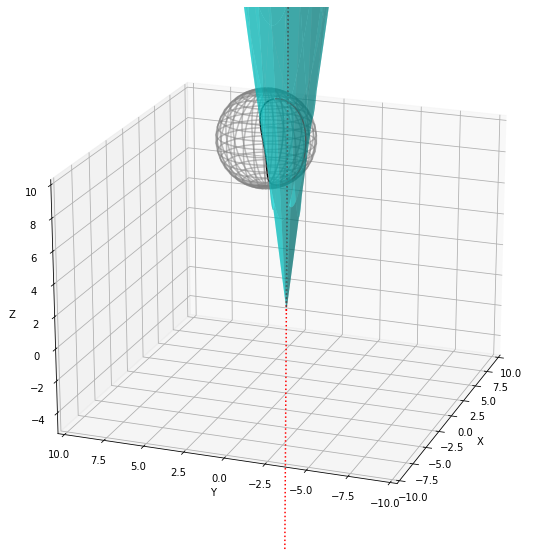

In [14]:
theta = 15  # Full opening angle
theta = np.deg2rad(theta)
c = np.sin(theta/2) # Conic opening parameter (R/H)


# Position of sphere center
x0 = 2
y0 = 2
z0 = 10
# Radius of Sphere
r  = 3

# Inclination in degrees
i = 5

# Evaluate model from -x to +x (+y and z)
extent = 20

# Calculate cone & grid
xs = np.linspace(-extent, extent,1000)
ys = np.linspace(-extent, extent,1000)
X, Y = np.meshgrid(xs,ys)
Z = np.sqrt((X**2 + Y**2)/c**2)

# Calculate z limits
z = np.linspace(-extent,extent,10000)

#%matplotlib 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# plot cone
surf = ax.plot_surface(X,Y,Z, alpha=0.5, color='cyan')

# Plot intersection lines
ax.plot(f_x1(z), f_y1(z), z, color='red')
ax.plot(f_x2(z), f_y2(z), z, color='black')
ax.set_zlim(-extent, extent)


# Plot Sphere
u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
x_sp = x0 + r*np.cos(u)*np.sin(v)
y_sp = y0 + r*np.sin(u)*np.sin(v)
z_sp = z0 + r*np.cos(v)
ax.plot_wireframe(x_sp, y_sp, z_sp, color="grey", alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-5,10)
ax.view_init(elev=20, azim=200)

m = 1 / np.tan(np.deg2rad(1)) # Gradient
xline = np.linspace(-0, extent, 10)
zline = m * xline
ax.plot(xline, [0]*10, zline, ls='dotted', color='red')

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
plt.show()

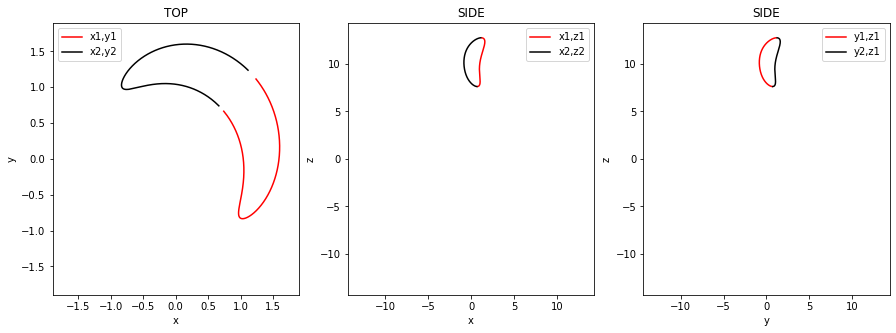

In [15]:
plot_projections(x1=f_x1(z), x2=f_x2(z), y1=f_y1(z), y2=f_y2(z), z1=z, z2=z)

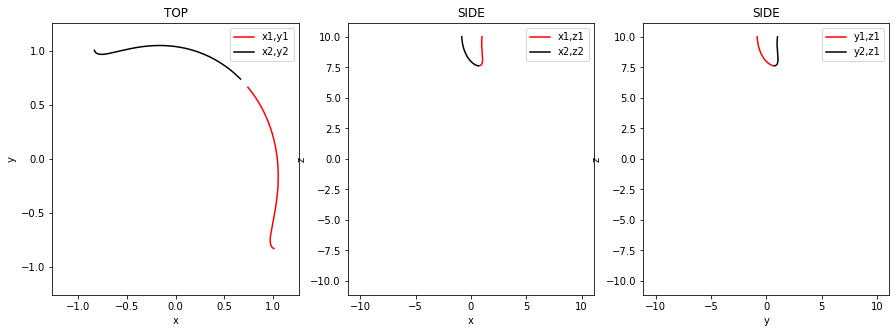

In [16]:
# Masking out non-illuminated area
# Although the cone's intersection may display a full area of the sphere
# In reality since only a part of the sphere will actually be illuminated
# Unless of course we take into account scattering of radiation from the cone itself
# We may obtain an approximation of this by masking out anything that has z > z0

mask = np.where(z < z0)
z_mask = z[mask]

plot_projections(x1=f_x1(z_mask), x2=f_x2(z_mask), y1=f_y1(z_mask), y2=f_y2(z_mask), z1=z_mask, z2=z_mask)

In [17]:
vecs1 = np.vstack([f_x1(z), f_y1(z), z]).T # [[x1,y1,z1],[x1,y2,z2],...[xn,yn,zn]]
vecs2 = np.vstack([f_x2(z), f_y2(z), z]).T

In [18]:
rot = R.from_euler('zyx', [0, i, 0], degrees=True)

In [19]:
vecs_rotated1 = rot.apply(vecs1)
vecs_rotated2 = rot.apply(vecs2)

In [20]:
x1_rot, y1_rot, z1_rot = vecs_rotated1.T
x2_rot, y2_rot, z2_rot = vecs_rotated2.T

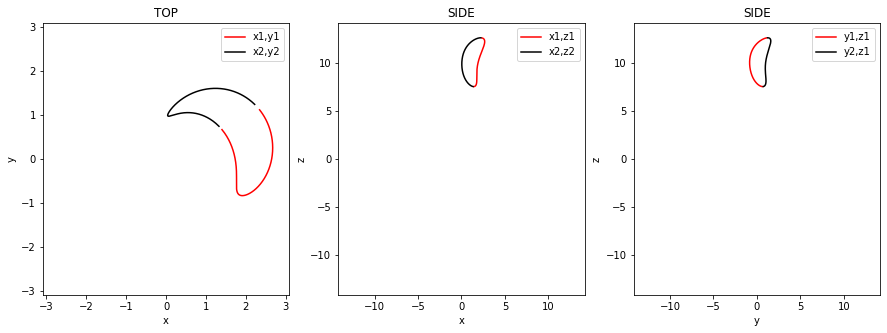

In [21]:
plot_projections(x1=x1_rot, x2=x2_rot, y1=y1_rot, y2=y2_rot, z1=z1_rot, z2=z2_rot)

In [22]:
idxs_x = np.where(np.diff(np.isnan(x1_rot)))[0] # indexs where the two parts of the curve start and end.
idxs_y = np.where(np.diff(np.isnan(y1_rot)))[0] # indexs where the two parts of the curve start and end.

In [23]:
if len(idxs_x) == 2:
    # One segment (grazing)
    x1_rot_seg1 = x1_rot[idxs_x[0]+1:idxs_x[1]]
    y1_rot_seg1 = y1_rot[idxs_y[0]+1:idxs_y[1]]
    x2_rot_seg1 = x2_rot[idxs_x[0]+1:idxs_x[1]]
    y2_rot_seg1 = y2_rot[idxs_y[0]+1:idxs_y[1]]

if len(idxs_x) == 4:
    # Two segments (full crossing)
    x1_rot_seg1 = x1_rot[idxs_x[0]+1:idxs_x[1]]
    x1_rot_seg2 = x1_rot[idxs_x[2]+1:idxs_x[3]]

    y1_rot_seg1 = y1_rot[idxs_y[0]+1:idxs_y[1]]
    y1_rot_seg2 = y1_rot[idxs_y[2]+1:idxs_y[3]]

    x2_rot_seg1 = x2_rot[idxs_x[0]+1:idxs_x[1]]
    x2_rot_seg2 = x2_rot[idxs_x[2]+1:idxs_x[3]]

    y2_rot_seg1 = y2_rot[idxs_y[0]+1:idxs_y[1]]
    y2_rot_seg2 = y2_rot[idxs_y[2]+1:idxs_y[3]]

In [24]:
area1 = area_signed(np.column_stack([x1_rot_seg1, y1_rot_seg1]))
area2 = area_signed(np.column_stack([x2_rot_seg1, y2_rot_seg1]))

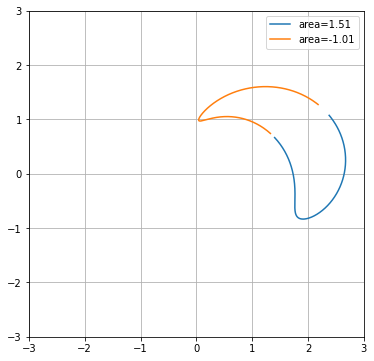

In [25]:
plt.figure(figsize=(6,6))
plt.plot(x1_rot_seg1, y1_rot_seg1, label=f'area={area1:.2f}')
plt.plot(x2_rot_seg1, y2_rot_seg1, label=f'area={area2:.2f}')

plt.xlim(-3,3)
plt.ylim(-3,3)

plt.grid()
plt.legend()

In [26]:
theta = 10
x0,y0,z0 = 0,1,10
r = 2
a = [x0,y0,z0]
a_norm = np.linalg.norm(a)
theta_2 = np.arccos(z0/a_norm)
theta_2_deg = np.rad2deg(theta_2)
b_norm = a_norm * np.cos(np.deg2rad(theta) - theta_2)
b_x = b_norm * np.cos(np.deg2rad(90 - theta))
b_z = b_norm * np.sin(np.deg2rad(90 - theta))

print(a)
print(a_norm)
print(theta_2)
print(theta_2_deg)
print(b_norm)
print(b_x)
print(b_z)
print(r)

# ab = -a + b
ab_x = -a[0] + b_x
ab_z = -a[2] + b_z

print(ab_x)
print(ab_z)

ab_norm = np.sqrt(ab_x**2 + ab_z**2)
print(ab_norm)

if r >= ab_norm:
    print('Intersection!')
elif r<ab_norm:
    print('Inside??')

[0, 1, 10]
10.04987562112089
0.09966865249116186
5.710593137499633
10.02172570778901
1.74025440623539
9.869473175592375
2
1.74025440623539
-0.13052682440762453
1.7451425873869528
Intersection!


In [27]:
np.deg2rad(90 - theta)

1.3962634015954636

In [28]:
y1_rot_seg1

array([0.66517896, 0.62932546, 0.60494036, ..., 1.0187443 , 1.04378196,
       1.07372342])

In [29]:
eq1

Eq((x**2 + y**2)/c**2, z**2)

In [30]:
theta = 10
theta = np.deg2rad(theta)
c = np.sin(theta/2)

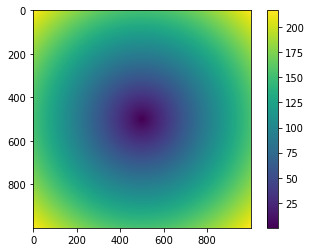

In [31]:
plt.imshow(Z)
plt.colorbar()

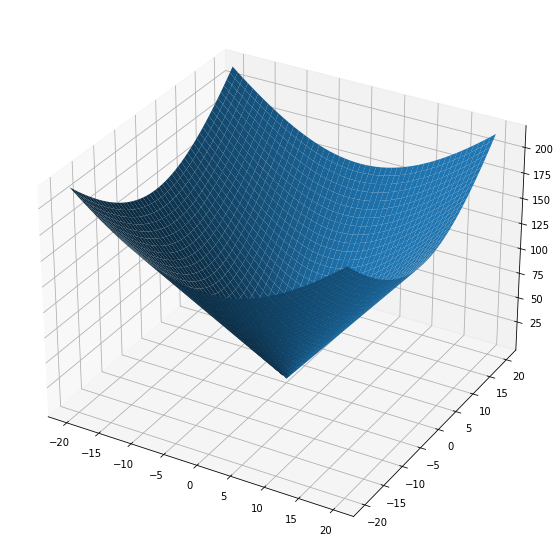

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection='3d')
surf = ax.plot_surface(X,Y,Z)
plt.show()